In [1]:
!pip install transformers

In [2]:
!pip install datasets jiwer

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.environ["WANDB_DISABLED"] = "true"

In [2]:
with open(r"F:\dataset\IIIT-HW-Dev\hindi_vocab.txt", encoding='utf-8') as f:
    vocab = f.readlines()
print(vocab[100])

उज्ज्वल



In [3]:
len(vocab)

11031

In [4]:
with open(r"F:\dataset\IIIT-HW-Dev\train.txt", encoding='utf-8') as f:
    train = f.readlines()

counter = 0

train_list = []
for i in range(len(train)):
    if counter > 50000:
        break
    image_id = train[i].split("\n")[0].split(' ')[0].strip()
#     vocab_id = int(train[i].split(",")[1].strip())
    text = train[i].split("\n")[0].split(' ')[1].strip()
    row = [image_id, text]
    train_list.append(row)
    counter += 1

train_df = pd.DataFrame(train_list, columns=['file_name', 'text'])
train_df.head()

,file_name,text
0,HindiSeg/train/10/259/1.jpg,हांगकांग
1,HindiSeg/train/10/259/2.jpg,लिलेश्वर
2,HindiSeg/train/10/259/3.jpg,आयडीन
3,HindiSeg/train/10/259/4.jpg,सिखावन
4,HindiSeg/train/10/259/5.jpg,विकिपीडिया


In [5]:
with open(r"F:\dataset\IIIT-HW-Dev\test.txt", encoding='utf-8') as f:
    test = f.readlines()

counter = 0
test_list = []
for i in range(len(test)):
    if counter > 10000:
        break
    image_id = test[i].split("\n")[0].split(' ')[0].strip()
#     vocab_id = int(train[i].split(",")[1].strip())
    text = test[i].split("\n")[0].split(' ')[1].strip()
    row = [image_id, text]
    test_list.append(row)
    counter += 1

test_df = pd.DataFrame(test_list, columns=['file_name', 'text'])
test_df.head()


,file_name,text
0,HindiSeg/test/6/3/1.jpg,गैर-चुनावी
1,HindiSeg/test/6/3/2.jpg,सबने
2,HindiSeg/test/6/3/3.jpg,रंगरेजवा
3,HindiSeg/test/6/3/4.jpg,शास्त्री
4,HindiSeg/test/6/3/5.jpg,रेस्त्राँ


In [6]:
with open(r"F:\dataset\IIIT-HW-Dev\val.txt", encoding='utf-8') as f:
    val = f.readlines()
counter = 0
val_list = []
for i in range(len(val)):
    if counter > 10000:
        break
    image_id = val[i].split("\n")[0].split(' ')[0].strip()
#     vocab_id = int(train[i].split(",")[1].strip())
    text = val[i].split("\n")[0].split(' ')[1].strip()
    row = [image_id, text]
    val_list.append(row)
    counter += 1
    
val_df = pd.DataFrame(val_list, columns=['file_name', 'text'])
val_df.head()


,file_name,text
0,HindiSeg/val/3/3/1.jpg,सामरिक
1,HindiSeg/val/3/3/2.jpg,केबिल्स
2,HindiSeg/val/3/3/3.jpg,आलोचनात्मक
3,HindiSeg/val/3/3/4.jpg,सीधीऔर
4,HindiSeg/val/3/3/5.jpg,ठाक


In [7]:
print(train_df.shape, test_df.shape, val_df.shape)

(50001, 2) (10001, 2) (10001, 2)


In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + '\\'+ file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
#         print(encoding)
        return encoding

In [9]:
from transformers import ViTFeatureExtractor, RobertaTokenizer, TrOCRProcessor, PreTrainedTokenizerFast
from transformers import VisionEncoderDecoderModel
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import PreTrainedTokenizerFast
encode = 'google/vit-base-patch16-224-in21k'
decode = 'amitness/roberta-base-ne'

feature_extractor=ViTFeatureExtractor.from_pretrained(encode)
tokenizer = RobertaTokenizer.from_pretrained(decode)
#tokenizer = PreTrainedTokenizerFast.from_pretrained(decode)
processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)

from transformers import TrOCRProcessor

train_dataset = IAMDataset(root_dir=r"F:\dataset\IIIT-HW-Dev",
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir=r"F:\dataset\IIIT-HW-Dev",
                           df=test_df,
                           processor=processor)

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encode, decode)

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
print(processor.tokenizer.pad_token_id)
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# config_decoder.is_decoder = True
# config_decoder.add_cross_attention = True

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

C:\Users\Tulad\miniconda3\envs\ocr\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
C:\Users\Tulad\miniconda3\envs\ocr\Lib\site-packages\transformers\models\trocr\processing_trocr.py:46: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(
C:\Users\Tulad\miniconda3\envs\ocr\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at amitness/roberta-base-ne and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.LayerNo

1


In [10]:
# !huggingface-cli

In [11]:
# from transformers import TrOCRProcessor

# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# train_dataset = IAMDataset(root_dir='../input/indic-handwritten-text-malayalam/train/train/',
#                            df=train_df,
#                            processor=processor)
# eval_dataset = IAMDataset(root_dir='../input/indic-handwritten-text-malayalam/test/test/',
#                            df=test_df,
#                            processor=processor)

In [12]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 50001
Number of validation examples: 10001


In [13]:
print(type(train_dataset[0]))

<class 'dict'>


In [14]:
type(train_dataset)
encoding = train_dataset[10]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([128])


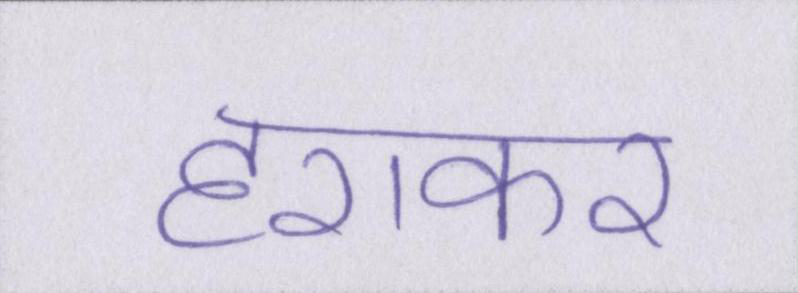

In [15]:
image = Image.open(train_dataset.root_dir +'\\'+ train_df['file_name'][10]).convert("RGB")
image

In [16]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

हराकर


In [17]:
# from transformers import VisionEncoderDecoderModel

# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

In [18]:
# # set special tokens used for creating the decoder_input_ids from the labels
# model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
# model.config.pad_token_id = processor.tokenizer.pad_token_id
# # make sure vocab size is set correctly
# model.config.vocab_size = model.config.decoder.vocab_size

# # set beam search parameters
# model.config.eos_token_id = processor.tokenizer.sep_token_id
# model.config.max_length = 64
# model.config.early_stopping = True
# model.config.no_repeat_ngram_size = 3
# model.config.length_penalty = 2.0
# model.config.num_beams = 4

In [35]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=500,
    fp16=True,
    num_train_epochs=5,
    save_total_limit=3,
    learning_rate=5e-5,
    #gradient_accumulation_steps=2,  # Simulates a larger batch size
    #dataloader_num_workers=4,  # Use multiple workers for data loading
)

C:\Users\Tulad\miniconda3\envs\ocr\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [36]:
from datasets import load_metric
cer_metric = load_metric("cer")

In [37]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [38]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

C:\Users\Tulad\miniconda3\envs\ocr\Lib\site-packages\transformers\models\trocr\processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
500,1.939600,1.901740,0.938912
1000,1.189800,1.150939,0.583860
1500,0.756000,0.824436,0.470368
2000,0.399900,0.663756,0.377472
2500,0.382700,0.549951,0.308286
3000,0.296300,0.474673,0.289696
3500,0.226600,0.442909,0.256902
4000,0.238100,0.376026,0.214570
4500,0.167800,0.359096,0.208446
5000,0.093000,0.317371,0.179801


C:\Users\Tulad\miniconda3\envs\ocr\Lib\site-packages\transformers\generation\utils.py:1283: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConf

TrainOutput(global_step=7815, training_loss=0.45569624132068587, metrics={'train_runtime': 74565.9877, 'train_samples_per_second': 3.353, 'train_steps_per_second': 0.105, 'total_flos': 3.2457248421841797e+19, 'train_loss': 0.45569624132068587, 'epoch': 5.0})

In [53]:
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained(r"F:\indic-trocr-0.0.1\notebooks\checkpoint-5000")

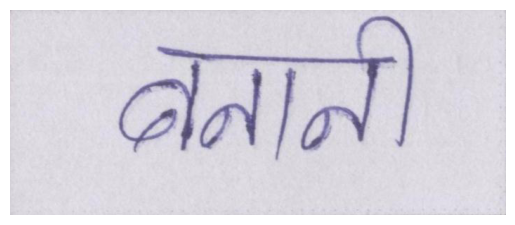

बनानी


In [64]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open(r"F:\dataset\IIIT-HW-Dev\HindiSeg\test/9/15/34.jpg").convert("RGB")
# Move model to the appropriate device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Process the image and move pixel values to the same device as the model
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# Generate predictions
with torch.no_grad():  # Disable gradient tracking
    generated_ids = model.generate(pixel_values)

# Decode the generated text
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

# Print the generated text
print(generated_text)

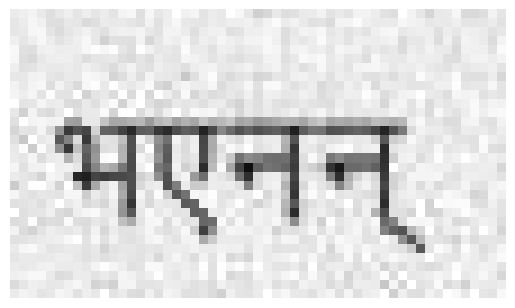

सपन


In [60]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open(r"E:\Image_generator\TextRecognitionDataGenerator-master\trdg\out\भएनन्_79.jpg").convert("RGB")
# Move model to the appropriate device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Process the image and move pixel values to the same device as the model
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# Generate predictions
with torch.no_grad():  # Disable gradient tracking
    generated_ids = model.generate(pixel_values)

# Decode the generated text
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

# Print the generated text
print(generated_text)